In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
# paths (on my laptop; cahnge for own paths)
train_dir = r"C:\Users\chris\Downloads\eclipse-megamovie\train"
csv_file = r"C:\Users\chris\Downloads\eclipse-megamovie\train.csv"

# load csv without header
df = pd.read_csv(csv_file)

# sample
print(df.head())

# construct full image paths
df['path'] = df['image_id'].apply(lambda x: os.path.join(train_dir, x))


                                            image_id  label
0  0089d49c892b6d15513690521c08eb5ffc93fe24a4926c...      0
1  00ade9976af2090eae8e6e5eed3096f12dc7235adb3c12...      0
2  ff6c7fea709fd7bbb1790668dc664b30ed72cfb2cae0a0...      0
3  eee7f9abf29297179aa070518671bfc9a60c9f8a67e62a...      0
4  fcc12656dacc1867bbea8438635bf52b4b1920cac3e48b...      0


In [3]:
def show_random_sift_keypoints(df, size=(512, 512)):
    sample = df.sample(1).iloc[0]
    image_path = sample['path']
    label = sample['label']
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return
    
    img = cv2.resize(img, size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # SIFT detector (contrastThreshold and edgeThreshold edited from defaults 0.04 and 10 respectively)
    sift = cv2.SIFT_create(contrastThreshold=0.01, edgeThreshold=5)
    keypoints = sift.detect(gray, None)

    # draw keypoints
    img_kp = cv2.drawKeypoints(
        img, keypoints, None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"SIFT Keypoints (Label: {label}) - {len(keypoints)} keypoints")
    plt.show()

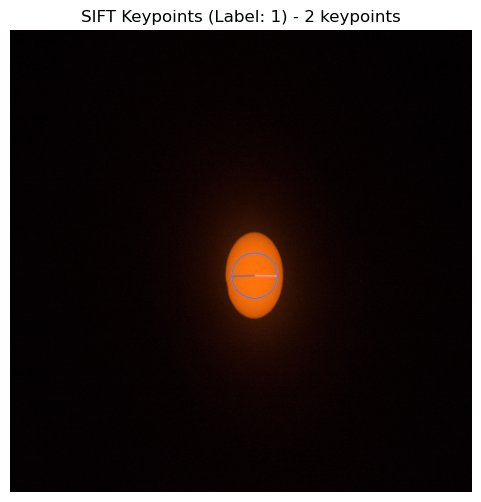

In [4]:
show_random_sift_keypoints(df)

In [5]:
# show n random images to visualize
def show_n_sift_keypoints(df, n=5, size=(512, 512)):
    samples = df.sample(n)
    plt.figure(figsize=(15, 15))
    
    for i, (_, row) in enumerate(samples.iterrows()):
        img = cv2.imread(row['path'])
        if img is None:
            continue
        img = cv2.resize(img, size)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create(contrastThreshold=0.005, edgeThreshold=3)
        keypoints = sift.detect(gray, None)
        img_kp = cv2.drawKeypoints(
            img, keypoints, None,
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )
        plt.subplot(1, n, i+1)
        plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Label: {row['label']} | {len(keypoints)} kp")

    plt.tight_layout()
    plt.show()

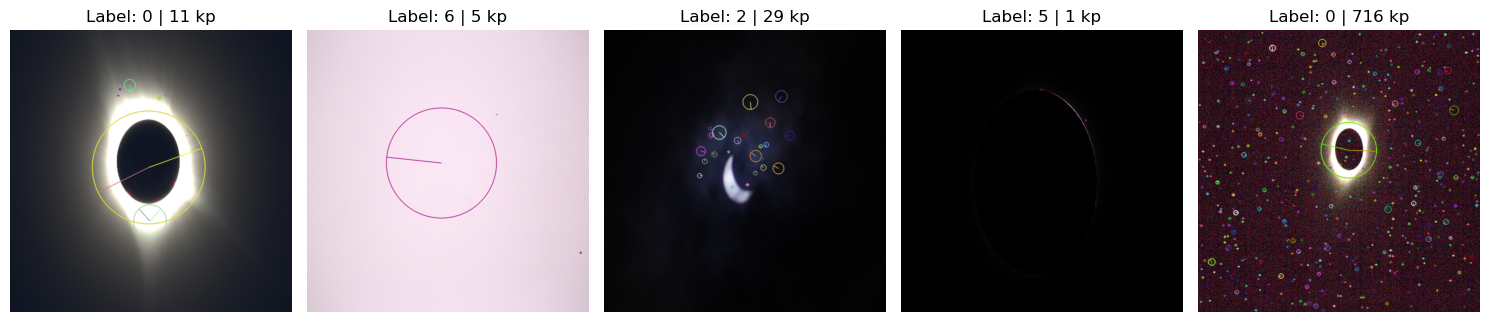

In [6]:
show_n_sift_keypoints(df)

In [7]:
def show_sift_keypoints_with_equalization(df, size=(512, 512)):
    sample = df.sample(1).iloc[0]
    image_path = sample['path']
    label = sample['label']
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return
    
    img = cv2.resize(img, size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # histogram equalization
    gray_eq = cv2.equalizeHist(gray)

    # orrrrrr
    # clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    # gray_eq = clahe.apply(gray)
    
    # SIFT detector with enhanced contrast image
    sift = cv2.SIFT_create(contrastThreshold=0.04, edgeThreshold=10)
    keypoints = sift.detect(gray_eq, None)

    # draw keypoints
    img_kp = cv2.drawKeypoints(
        img, keypoints, None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"SIFT Keypoints with Equalization (Label: {label}) - {len(keypoints)} keypoints")
    plt.show()


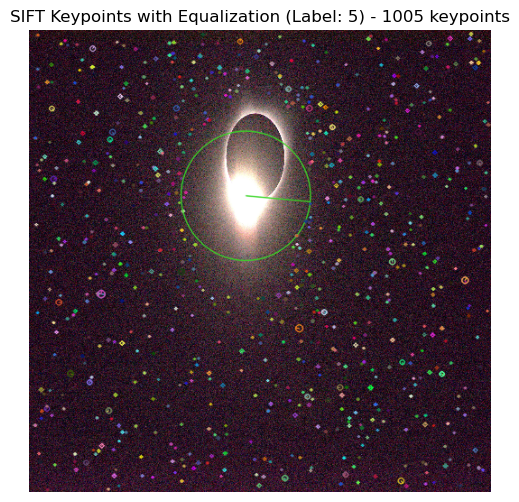

In [8]:
show_sift_keypoints_with_equalization(df)

In [9]:
def show_sift_keypoints_filtered(df, size=(512, 512)):
    sample = df.sample(1).iloc[0]
    image_path = sample['path']
    label = sample['label']
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return
    
    img = cv2.resize(img, size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    gray_eq = clahe.apply(gray)

    # gaussian blur to suppress noise
    gray_blurred = cv2.GaussianBlur(gray_eq, (3, 3), 0)

    # SIFT detector with less sensitivity to noise
    sift = cv2.SIFT_create(contrastThreshold=0.04, edgeThreshold=10)
    keypoints = sift.detect(gray_blurred, None)

    # filter out small keypoints
    keypoints = [kp for kp in keypoints if kp.size > 3]

    # draw keypoints on original image
    img_kp = cv2.drawKeypoints(
        img, keypoints, None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    # original image
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Original Image (Label: {label})")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"SIFT Keypoints - {len(keypoints)} detected")

    plt.tight_layout()
    plt.show()

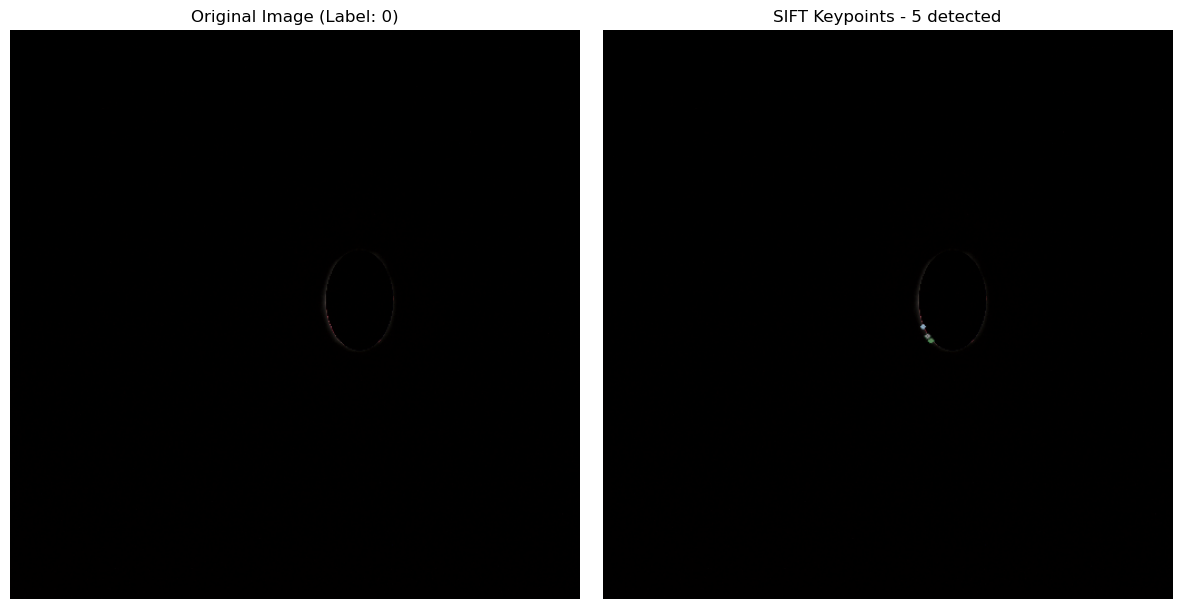

In [10]:
show_sift_keypoints_filtered(df)

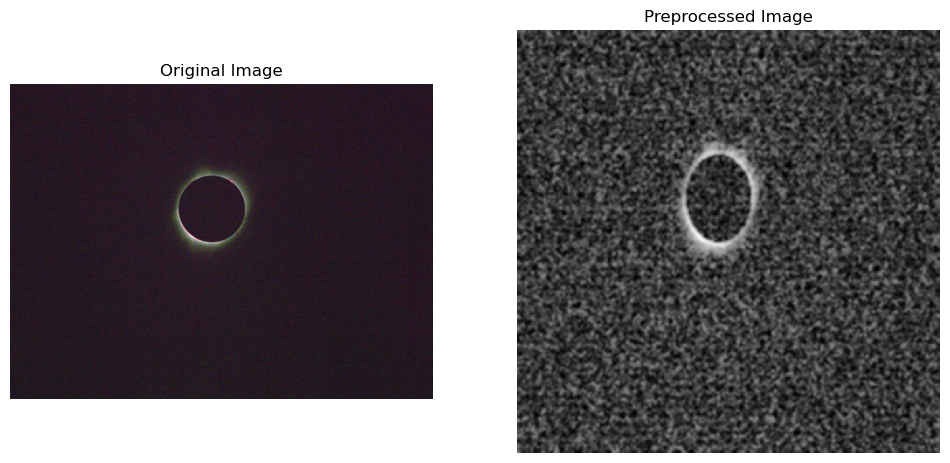

Extracting SIFT features: 100%|██████████████████████████████████████████████████████| 140/140 [02:40<00:00,  1.15s/it]


Running GridSearchCV...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best SVM Parameters: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Test Accuracy: 0.7429


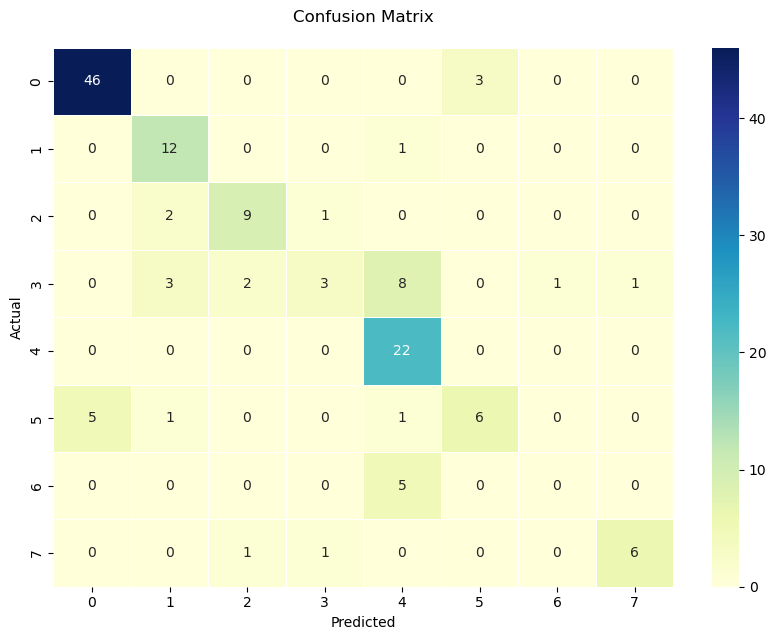

              precision    recall  f1-score   support

           0       0.90      0.94      0.92        49
           1       0.67      0.92      0.77        13
           2       0.75      0.75      0.75        12
           3       0.60      0.17      0.26        18
           4       0.59      1.00      0.75        22
           5       0.67      0.46      0.55        13
           6       0.00      0.00      0.00         5
           7       0.86      0.75      0.80         8

    accuracy                           0.74       140
   macro avg       0.63      0.62      0.60       140
weighted avg       0.72      0.74      0.71       140



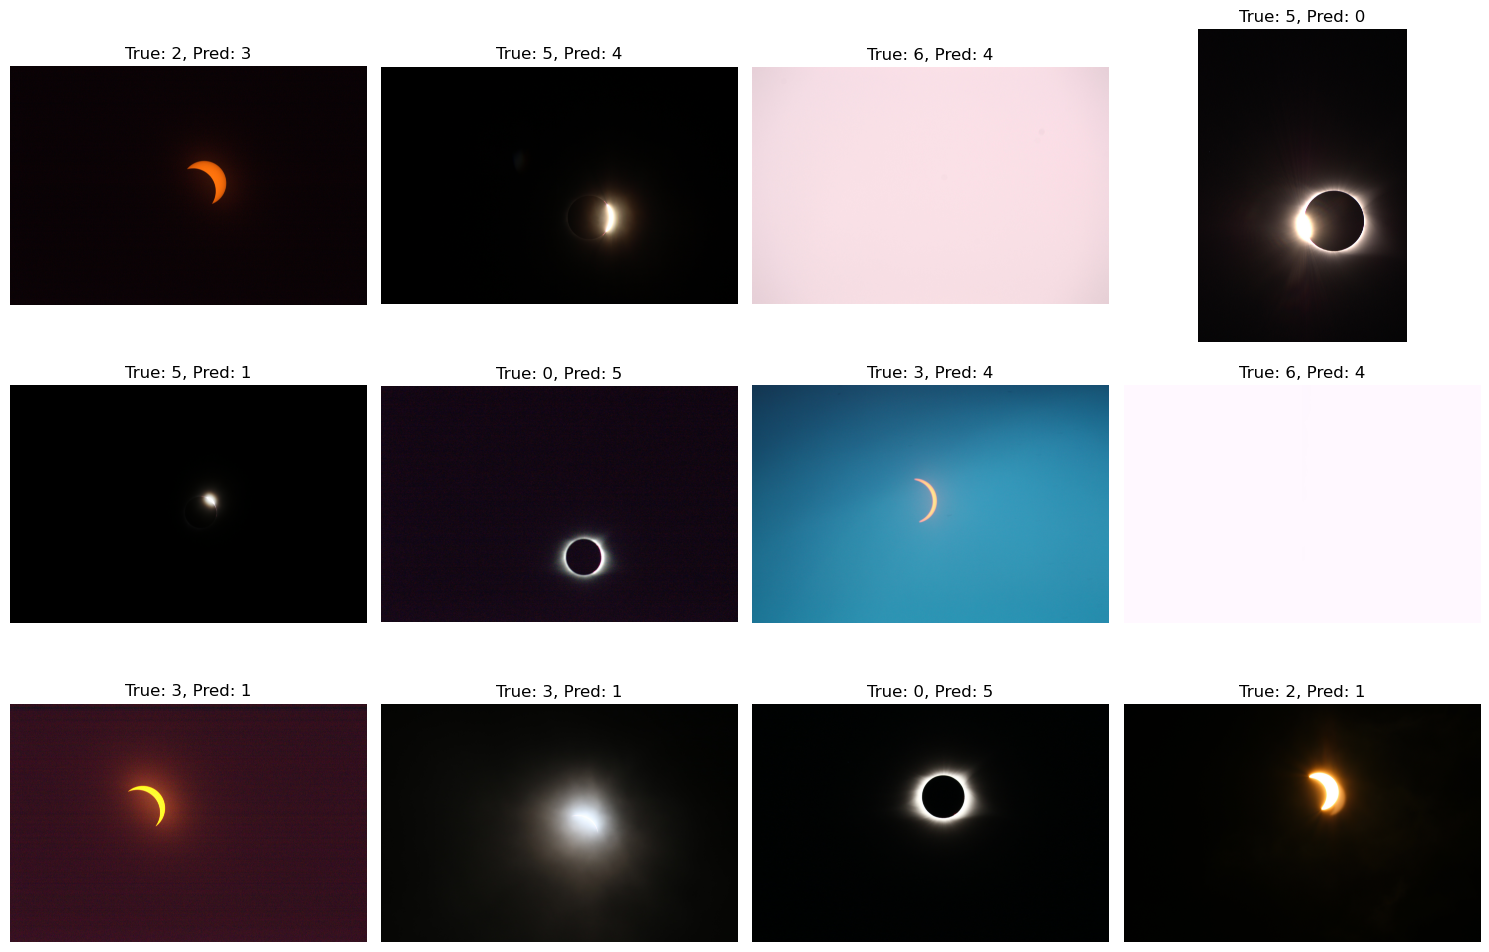

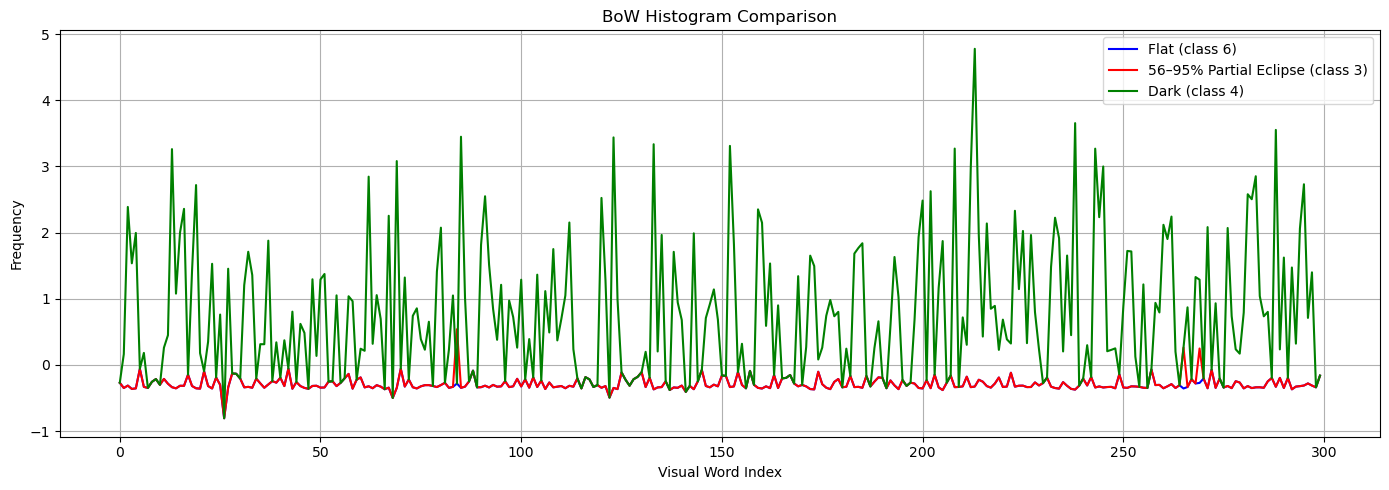

In [14]:
# paths
train_dir = r"C:\Users\chris\Downloads\eclipse-megamovie\train"
test_dir = r"C:\Users\chris\Downloads\eclipse-megamovie\test"
train_csv = r"C:\Users\chris\Downloads\eclipse-megamovie\train.csv"
test_csv = r"C:\Users\chris\Downloads\eclipse-megamovie\test.csv"

# load label files
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# add full paths
train_df['path'] = train_df['image_id'].apply(lambda x: os.path.join(train_dir, x))
test_df['path'] = test_df['image_id'].apply(lambda x: os.path.join(test_dir, x))

# preprocessing
def preprocess_image(path, size=(256, 256)):
    img = cv2.imread(path) # read image from file path
    if img is None: # handle error image
        return None
    img = cv2.resize(img, size) # resize to 512x512
    img = cv2.GaussianBlur(img, (3, 3), 0) # apply gaussian blur to reduce noise (too many keypoints)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert image to grayscale (bad idea?)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) # create CLAHE - used to enhonace contrast
    return clahe.apply(gray) # return preprocessed image, CLAHE applied here

# SIFT - feature extract
def extract_sift_descriptors(df, special_classifications):
    sift = cv2.SIFT_create(contrastThreshold=0.075, edgeThreshold=12)
    descriptors_list = []

    for idx, path in enumerate(tqdm(df['path'], desc="Extracting SIFT features")):
        img = cv2.imread(path)
        if img is None:
            descriptors_list.append(None)
            special_classifications.append(None)
            continue

        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Early classify as Flat or Dark based on original grayscale image
        special_class = classify_flat_or_dark(img_gray, debug=False, path=path)
        if special_class is not None:
            special_classifications.append(special_class)
            descriptors_list.append(None)
            continue  # Skip SIFT extraction

        # Preprocess the image (resize, blur, CLAHE)
        gray = preprocess_image(path)
        if gray is None:
            descriptors_list.append(None)
            special_classifications.append(None)
            continue

        keypoints, descriptors = sift.detectAndCompute(gray, None)
        descriptors_list.append(descriptors)
        special_classifications.append(None)

    return descriptors_list


# kmeans
def build_vocabulary(descriptors_list, vocab_size): # vocab_size = number of clusters(visual words) to ceate in vocabulary
    descriptors = [desc for desc in descriptors_list if desc is not None] # filter out none values (bad?)
    descriptors = np.vstack(descriptors) # used as large matrix containing alldescriptors - used for clustering
    kmeans = KMeans(n_clusters=vocab_size, random_state=42)#, batch_size=1000) # might be better to try KMeans instead (I thought of this wrong)
    kmeans.fit(descriptors) # fit KMeans model to descriptors - tries to group them into vocab_size clusters
    return kmeans # contains the visual words - used to represent each image's features as histograms of visual words

def compute_bow_histograms(descriptors_list, kmeans, special_classifications):
    vocab_size = kmeans.n_clusters
    histograms = []
    
    for descriptors, special_class in zip(descriptors_list, special_classifications):
        if special_class is not None:
            # Special case (Flat/Dark) — set dummy histogram
            hist = np.zeros(vocab_size)
        elif descriptors is None:
            hist = np.zeros(vocab_size)
        else:
            words = kmeans.predict(descriptors)
            hist, _ = np.histogram(words, bins=np.arange(vocab_size + 1))
        
        histograms.append(hist)
    
    return np.array(histograms)

def classify_flat_or_dark(img, flat_std_thresh=8, dark_mean_thresh=25, dark_std_thresh=6, debug=False, path=""):
    """
    Classify an image as Flat (6), Dark (4), or Unknown (None).
    
    Parameters:
    - img: grayscale image (numpy array)
    - flat_std_thresh: std deviation threshold for Flat
    - dark_mean_thresh: mean intensity threshold for Dark
    - dark_std_thresh: std deviation threshold for Dark
    - debug: if True, prints out stats and plots histogram
    - path: optional image path for labeling plots
    """
    if img is None:
        return None

    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    median_intensity = np.median(img)

    # Compute histogram
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    dominant_pixel = np.argmax(hist)

    if debug:
        print(f"[DEBUG] {path} -> Mean: {mean_intensity:.2f}, Std: {std_intensity:.2f}, Median: {median_intensity:.2f}, Dominant pixel: {dominant_pixel}")

        plt.figure(figsize=(8, 4))
        plt.plot(hist, color='blue')
        plt.title(f"Histogram for {path}")
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    # Rule for Dark: very dim, low contrast, dominant near 0
    if mean_intensity < dark_mean_thresh and std_intensity < dark_std_thresh and dominant_pixel < 20:
        return 4  # Dark

    # Rule for Flat: bright or mid-bright, but low variation, dominant peak not too dark
    elif mean_intensity > 80 and std_intensity < flat_std_thresh and dominant_pixel > 50:
        return 6  # Flat

    # Otherwise unknown
    return None

# Load the original image
original_path = train_df['path'].iloc[0]

# Preprocess the image
preprocessed_img = preprocess_image(original_path)

# Load the original image for comparison
original_img = cv2.imread(original_path)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Create a figure with 1 row and 2 columns for side-by-side comparison
plt.figure(figsize=(12, 6))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(original_img_rgb)
plt.title("Original Image")
plt.axis('off')

# Plot the preprocessed image
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_img, cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')

# Show the plot
plt.show()

# execute
# extract descriptors
#train_descriptors = extract_sift_descriptors(train_df) 
#test_descriptors = extract_sift_descriptors(test_df)
# classify special cases first
special_classifications_train = []
special_classifications_test = []

train_descriptors = extract_sift_descriptors(train_df, special_classifications_train)
test_descriptors = extract_sift_descriptors(test_df, special_classifications_test)


# build vocabulary from training data
vocab_size = 300
kmeans = build_vocabulary(train_descriptors, vocab_size)

# compute BoW histograms
X_train = compute_bow_histograms(train_descriptors, kmeans, special_classifications_train)
X_test = compute_bow_histograms(test_descriptors, kmeans, special_classifications_test)

# normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# train classifier
# train labels
y_train = []

for original_label, special_label in zip(train_df['label'].values, special_classifications_train):
    if special_label is not None:
        y_train.append(special_label)
    else:
        y_train.append(original_label)

y_train = np.array(y_train)

# test labels
y_test = []

for original_label, special_label in zip(test_df['label'].values, special_classifications_test):
    if special_label is not None:
        y_test.append(special_label)
    else:
        y_test.append(original_label)

y_test = np.array(y_test)

#y_train = train_df['label'].values
#y_test = test_df['label'].values

# === GRID SEARCH CV FOR SVM ===
param_grid = {
    'C': [1, 10, 100, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['rbf']
}

print("Running GridSearchCV...")
grid = GridSearchCV(SVC(), param_grid, cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best SVM Parameters:", grid.best_params_)
svm = grid.best_estimator_

#svm = SVC(kernel='rbf', C=10, gamma=0.01)
#svm.fit(X_train, y_train)

# evaluate
y_pred = svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# confusion matrix
labels = np.arange(8)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(10, 7))
plt.title("Confusion Matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(classification_report(y_test, y_pred))

# Get indices where the prediction was wrong
misclassified_indices = np.where(y_pred != y_test)[0]

# Number of misclassified images to show
num_to_show = 12
plt.figure(figsize=(15, 10))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    path = test_df.iloc[idx]['path']
    true_label = y_test[idx]
    predicted_label = y_pred[idx]

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Get indices for each class
flat_idx = np.where(train_df['label'] == 6)[0][0]      # First Flat
partial_idx = np.where(train_df['label'] == 3)[0][0]   # First 56-95% Partial Eclipse
dark_idx = np.where(train_df['label'] == 4)[0][0]      # First Dark

# Extract corresponding histograms
flat_hist = X_train[flat_idx]
partial_hist = X_train[partial_idx]
dark_hist = X_train[dark_idx]

# Plot
plt.figure(figsize=(14, 5))
plt.plot(flat_hist, label="Flat (class 6)", color='blue')
plt.plot(partial_hist, label="56–95% Partial Eclipse (class 3)", color='red')
plt.plot(dark_hist, label="Dark (class 4)", color='green')
plt.title("BoW Histogram Comparison")
plt.xlabel("Visual Word Index")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Processing Training Data...


Extracting SIFT features: 100%|██████████████████████████████████████████████████████| 495/495 [10:14<00:00,  1.24s/it]


Processing Test Data...


Extracting SIFT features: 100%|██████████████████████████████████████████████████████| 140/140 [02:44<00:00,  1.17s/it]


Training set: 495 total, 43 special, 423 normal with valid descriptors.
Test set: 140 total, 10 special, 121 normal with valid descriptors.
Building vocabulary from 423 images (77077 total descriptors)...
Computing BoW histograms for Normal training images...
Computing BoW histograms for Normal test images...
Training SVM on Normal images...
Running GridSearchCV...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\chris\miniconda3\envs\tflabsfall24\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best SVM Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

--- Final Evaluation ---
Overall Test Accuracy: 0.7786


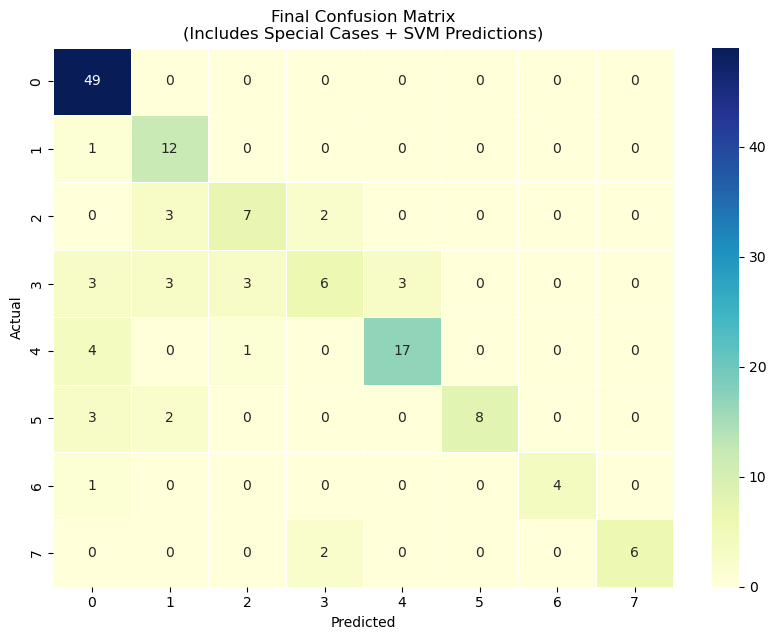

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        49
           1       0.60      0.92      0.73        13
           2       0.64      0.58      0.61        12
           3       0.60      0.33      0.43        18
           4       0.85      0.77      0.81        22
           5       1.00      0.62      0.76        13
           6       1.00      0.80      0.89         5
           7       1.00      0.75      0.86         8

    accuracy                           0.78       140
   macro avg       0.81      0.72      0.75       140
weighted avg       0.79      0.78      0.77       140


Found 31 misclassified images.


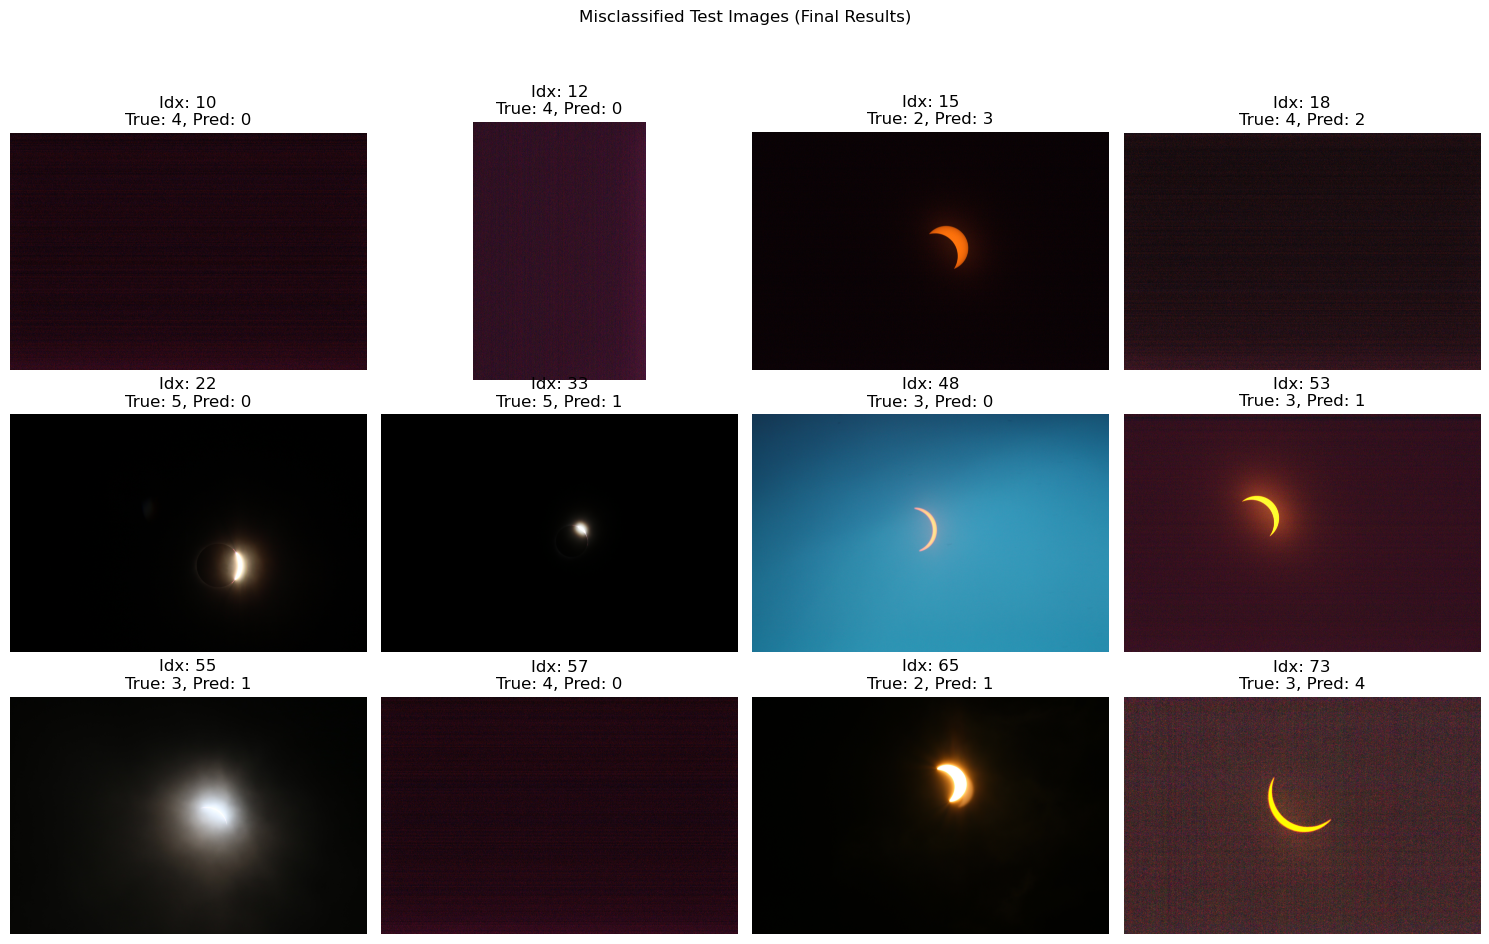

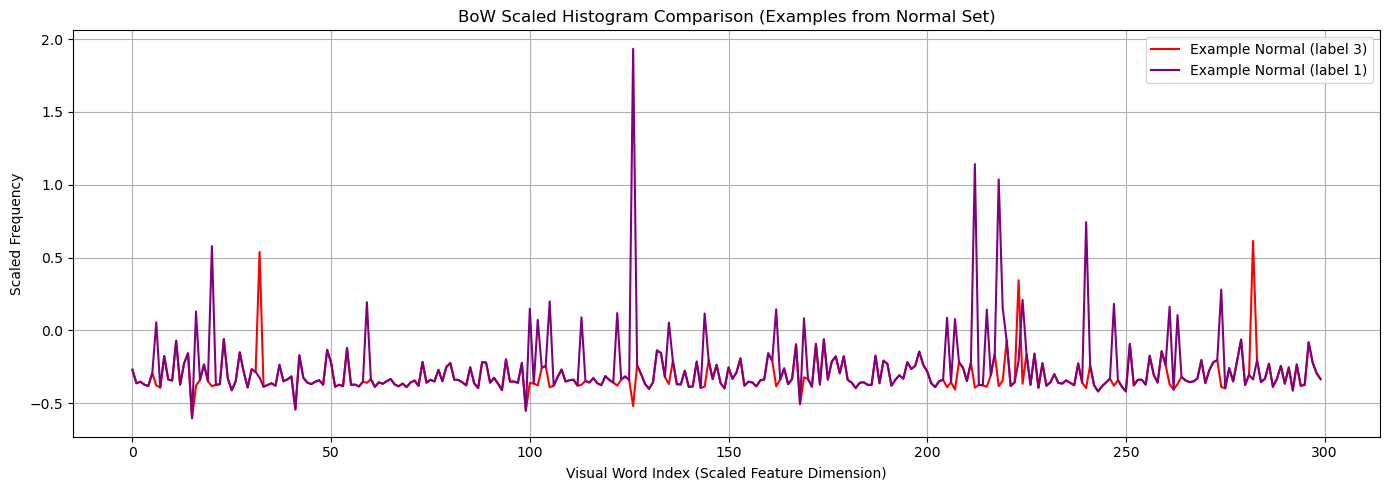


Script finished.


In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- Paths ---
# Make sure these paths are correct for your system
train_dir = r"C:\Users\chris\Downloads\eclipse-megamovie\train"
test_dir = r"C:\Users\chris\Downloads\eclipse-megamovie\test"
train_csv = r"C:\Users\chris\Downloads\eclipse-megamovie\train.csv"
test_csv = r"C:\Users\chris\Downloads\eclipse-megamovie\test.csv"

# --- Load label files ---
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# --- Add full paths ---
train_df['path'] = train_df['image_id'].apply(lambda x: os.path.join(train_dir, x))
test_df['path'] = test_df['image_id'].apply(lambda x: os.path.join(test_dir, x))

# --- Preprocessing ---
def preprocess_image(path, size=(256, 256)):
    img = cv2.imread(path) # read image from file path
    if img is None: # handle error image
        print(f"Warning: Could not read image {path}")
        return None
    img = cv2.resize(img, size) # resize to 256x256
    img = cv2.GaussianBlur(img, (3, 3), 0) # apply gaussian blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert image to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) # create CLAHE
    return clahe.apply(gray) # return preprocessed image, CLAHE applied

# --- Special Case Classification ---
def classify_flat_or_dark(img, flat_std_thresh=8, dark_mean_thresh=25, dark_std_thresh=6, debug=False, path=""):
    """ Classify an image as Flat (6), Dark (4), or Unknown (None). """
    if img is None:
        return None

    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    median_intensity = np.median(img)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    dominant_pixel = np.argmax(hist)

    if debug:
        print(f"[DEBUG] {path} -> Mean: {mean_intensity:.2f}, Std: {std_intensity:.2f}, Median: {median_intensity:.2f}, Dominant pixel: {dominant_pixel}")
        # (Optional: add histogram plotting code here if needed)

    # Rule for Dark: very dim, low contrast, dominant near 0
    if mean_intensity < dark_mean_thresh and std_intensity < dark_std_thresh and dominant_pixel < 20:
        return 4  # Dark

    # Rule for Flat: bright or mid-bright, but low variation, dominant peak not too dark
    elif mean_intensity > 80 and std_intensity < flat_std_thresh and dominant_pixel > 50:
        return 6  # Flat

    return None # Otherwise unknown

# --- SIFT - feature extract (No change needed here) ---
def extract_sift_descriptors(df):
    sift = cv2.SIFT_create(contrastThreshold=0.075, edgeThreshold=12)
    descriptors_list = []
    special_classifications = [] # Store special class (4 or 6) or None

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting SIFT features"):
        path = row['path']
        img_orig = cv2.imread(path) # Read original for classification
        if img_orig is None:
            print(f"Warning: Could not read original image {path} for special classification.")
            descriptors_list.append(None)
            special_classifications.append(None)
            continue

        img_gray_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

        # --- Early classify as Flat or Dark based on original grayscale image ---
        special_class = classify_flat_or_dark(img_gray_orig, debug=False, path=path)

        if special_class is not None:
            special_classifications.append(special_class) # Store 4 or 6
            descriptors_list.append(None) # No descriptors needed
            continue  # Skip SIFT extraction

        # --- If not Flat/Dark, proceed with preprocessing and SIFT ---
        special_classifications.append(None) # Mark as not special
        gray_processed = preprocess_image(path) # Preprocess for SIFT

        if gray_processed is None:
            descriptors_list.append(None) # Preprocessing failed
            continue

        keypoints, descriptors = sift.detectAndCompute(gray_processed, None)

        # Handle cases where no keypoints are found even if not Flat/Dark
        if descriptors is None or len(descriptors) == 0:
             descriptors_list.append(None)
        else:
            descriptors_list.append(descriptors)


    return descriptors_list, special_classifications

# --- KMeans Vocabulary Building (No change needed here) ---
def build_vocabulary(descriptors_list_normal, vocab_size):
    # Input should ONLY contain descriptors from non-Flat/Dark images
    descriptors = [desc for desc in descriptors_list_normal if desc is not None]
    if not descriptors:
        raise ValueError("No valid descriptors found to build vocabulary. Check SIFT extraction and filtering.")
    descriptors_stacked = np.vstack(descriptors)
    print(f"Building vocabulary from {len(descriptors)} images ({descriptors_stacked.shape[0]} total descriptors)...")
    kmeans = KMeans(n_clusters=vocab_size, random_state=42, n_init=10) # n_init added for stability
    kmeans.fit(descriptors_stacked)
    return kmeans

# --- Compute BoW Histograms (Slight adaptation for clarity/safety) ---
def compute_bow_histograms_normal(descriptors_list_normal, kmeans):
    # Input should ONLY contain descriptors from non-Flat/Dark images
    # Assumes Nones are filtered *before* calling or handled if passed
    vocab_size = kmeans.n_clusters
    histograms = []

    for descriptors in descriptors_list_normal:
        if descriptors is None or len(descriptors) == 0:
            # This case should ideally be minimized by filtering, but handle defensively
            hist = np.zeros(vocab_size)
        else:
            words = kmeans.predict(descriptors)
            hist, _ = np.histogram(words, bins=np.arange(vocab_size + 1))
        histograms.append(hist)

    return np.array(histograms)

# --- Execute Feature Extraction ---
print("Processing Training Data...")
train_descriptors_all, special_classifications_train = extract_sift_descriptors(train_df)
print("Processing Test Data...")
test_descriptors_all, special_classifications_test = extract_sift_descriptors(test_df)

# --- Filter Data: Separate Normal images from Flat/Dark ---

# 1. Get Indices
normal_train_indices = [i for i, sc in enumerate(special_classifications_train) if sc is None]
special_train_indices = [i for i, sc in enumerate(special_classifications_train) if sc is not None]
normal_test_indices = [i for i, sc in enumerate(special_classifications_test) if sc is None]
special_test_indices = [i for i, sc in enumerate(special_classifications_test) if sc is not None]

# 2. Filter Descriptors and Labels for NORMAL images (Handling potential None descriptors)
train_descriptors_normal_valid = []
y_train_normal_indices = [] # Keep track of original indices for labels
for i in normal_train_indices:
    if train_descriptors_all[i] is not None and len(train_descriptors_all[i]) > 0:
        train_descriptors_normal_valid.append(train_descriptors_all[i])
        y_train_normal_indices.append(i) # Store the original index

test_descriptors_normal_valid = []
y_test_normal_indices = [] # Keep track of original indices for combining later
for i in normal_test_indices:
     if test_descriptors_all[i] is not None and len(test_descriptors_all[i]) > 0:
        test_descriptors_normal_valid.append(test_descriptors_all[i])
        y_test_normal_indices.append(i) # Store the original index

# 3. Get Labels for NORMAL training images
y_train_normal = train_df['label'].values[y_train_normal_indices]

print(f"Training set: {len(train_df)} total, {len(special_train_indices)} special, {len(y_train_normal_indices)} normal with valid descriptors.")
print(f"Test set: {len(test_df)} total, {len(special_test_indices)} special, {len(y_test_normal_indices)} normal with valid descriptors.")

if not y_train_normal_indices:
    raise SystemExit("Error: No 'normal' images with valid descriptors found in the training set. Cannot proceed.")


# --- Build Vocabulary (using ONLY normal training images) ---
vocab_size = 300
kmeans = build_vocabulary(train_descriptors_normal_valid, vocab_size)

# --- Compute BoW Histograms (using ONLY normal images) ---
print("Computing BoW histograms for Normal training images...")
X_train_normal = compute_bow_histograms_normal(train_descriptors_normal_valid, kmeans)
print("Computing BoW histograms for Normal test images...")
X_test_normal = compute_bow_histograms_normal(test_descriptors_normal_valid, kmeans)

# --- Normalize Features (using ONLY normal images) ---
scaler = StandardScaler()
X_train_scaled_normal = scaler.fit_transform(X_train_normal)
# Check if X_test_normal is empty before transforming
if X_test_normal.shape[0] > 0:
    X_test_scaled_normal = scaler.transform(X_test_normal)
else:
    # Handle case where there are no normal test images with descriptors
    X_test_scaled_normal = np.empty((0, vocab_size))
    print("Warning: No 'normal' test images with valid descriptors found.")


# --- Train Classifier (using ONLY normal images) ---
print("Training SVM on Normal images...")
# === GRID SEARCH CV FOR SVM ===
param_grid = {
    'C': [1, 10, 100], # Reduced for potentially faster run, expand as needed
    'gamma': [0.001, 0.01, 0.1, 1], # Reduced for potentially faster run
    'kernel': ['rbf']
}

print("Running GridSearchCV...")
# Ensure there's data to train on
if X_train_scaled_normal.shape[0] > 0:
    grid = GridSearchCV(SVC(), param_grid, cv=min(3, X_train_scaled_normal.shape[0]), verbose=2, n_jobs=-1) # Adjust cv if dataset is small
    grid.fit(X_train_scaled_normal, y_train_normal)
    print("Best SVM Parameters:", grid.best_params_)
    svm = grid.best_estimator_
else:
    raise SystemExit("Error: Cannot train SVM, no valid normal training samples.")


# --- Predict with SVM (on ONLY normal test images) ---
# Ensure there's data to predict on
if X_test_scaled_normal.shape[0] > 0:
    y_pred_normal = svm.predict(X_test_scaled_normal)
else:
    y_pred_normal = np.array([], dtype=int) # No predictions if no normal test images


# --- Combine Predictions and Ground Truth ---

# 1. Final Ground Truth (y_test_final)
y_test_final = test_df['label'].values.copy() # Start with original labels
for i in special_test_indices:
    y_test_final[i] = special_classifications_test[i] # Override with special class

# 2. Final Predictions (y_pred_final)
y_pred_final = np.zeros(len(test_df), dtype=int) # Initialize

# Fill in special classifications
for i in special_test_indices:
    y_pred_final[i] = special_classifications_test[i]

# Fill in SVM predictions for normal images
# Ensure the lengths match before assigning
if len(y_pred_normal) == len(y_test_normal_indices):
    for pred_idx, original_idx in enumerate(y_test_normal_indices):
        y_pred_final[original_idx] = y_pred_normal[pred_idx]
elif len(y_pred_normal) == 0 and len(y_test_normal_indices) == 0:
     print("No normal test images to predict.")
else:
    print(f"Warning: Mismatch in length of normal predictions ({len(y_pred_normal)}) and normal indices ({len(y_test_normal_indices)}). Predictions might be incomplete.")
    # Handle potential mismatches cautiously if necessary, e.g., leave as 0 or assign a specific error code


# --- Evaluate FINAL Results ---
print("\n--- Final Evaluation ---")
if len(y_test_final) > 0:
    acc = accuracy_score(y_test_final, y_pred_final)
    print(f"Overall Test Accuracy: {acc:.4f}")

    # Confusion Matrix
    # Dynamically get unique labels present in both true and pred for matrix plotting
    labels = sorted(list(set(y_test_final) | set(y_pred_final)))
    cm = confusion_matrix(y_test_final, y_pred_final, labels=labels)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=(10, 7))
    plt.title("Final Confusion Matrix\n(Includes Special Cases + SVM Predictions)")
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=0.5)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    print(classification_report(y_test_final, y_pred_final, labels=labels, zero_division=0))
else:
    print("No test data to evaluate.")


# --- Visualize Misclassified Images (Using Final Results) ---
if len(y_test_final) > 0:
    misclassified_indices = np.where(y_pred_final != y_test_final)[0]
    print(f"\nFound {len(misclassified_indices)} misclassified images.")

    # Number of misclassified images to show
    num_to_show = min(12, len(misclassified_indices)) # Show up to 12 or fewer if less are misclassified
    if num_to_show > 0:
        plt.figure(figsize=(15, 10))
        plot_rows = (num_to_show + 3) // 4 # Calculate rows needed for a 4-column layout
        for i, idx in enumerate(misclassified_indices[:num_to_show]):
            path = test_df.iloc[idx]['path']
            true_label = y_test_final[idx]
            predicted_label = y_pred_final[idx]

            img = cv2.imread(path)
            if img is None:
                print(f"Warning: Could not read image {path} for misclassified visualization.")
                # Optionally plot a placeholder
                ax = plt.subplot(plot_rows, 4, i + 1)
                ax.set_title(f"Idx: {idx}\nTrue: {true_label}, Pred: {predicted_label}\n(Image Read Error)")
                ax.axis('off')
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(plot_rows, 4, i + 1)
            plt.imshow(img)
            plt.title(f"Idx: {idx}\nTrue: {true_label}, Pred: {predicted_label}")
            plt.axis('off')

        plt.suptitle("Misclassified Test Images (Final Results)")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()


# --- Visualize Histogram Comparison (Focus on NORMAL classes) ---
# Find examples within the NORMAL, SCALED training data
if X_train_scaled_normal.shape[0] > 0:
    try:
        # Find first index in the 'normal' set corresponding to a specific original label
        partial_label_to_find = 3 # Example: 56–95% Partial Eclipse
        # Find the first occurrence of this label *within the set used for training SVM*
        target_indices_in_normal_set = np.where(y_train_normal == partial_label_to_find)[0]

        if len(target_indices_in_normal_set) > 0:
            partial_idx_in_normal = target_indices_in_normal_set[0]
            partial_hist = X_train_scaled_normal[partial_idx_in_normal]

            # Maybe compare two different 'normal' classes if available
            other_label_to_find = 1 # Example: 1-25% Partial Eclipse
            other_indices_in_normal_set = np.where(y_train_normal == other_label_to_find)[0]
            other_hist = None
            if len(other_indices_in_normal_set) > 0:
                 other_idx_in_normal = other_indices_in_normal_set[0]
                 other_hist = X_train_scaled_normal[other_idx_in_normal]


            # Plot
            plt.figure(figsize=(14, 5))
            plt.plot(partial_hist, label=f"Example Normal (label {partial_label_to_find})", color='red')
            if other_hist is not None:
                 plt.plot(other_hist, label=f"Example Normal (label {other_label_to_find})", color='purple')

            plt.title("BoW Scaled Histogram Comparison (Examples from Normal Set)")
            plt.xlabel("Visual Word Index (Scaled Feature Dimension)")
            plt.ylabel("Scaled Frequency")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Could not find example of label {partial_label_to_find} in the normal training set for histogram visualization.")

    except Exception as e:
        print(f"Could not generate histogram comparison plot: {e}")
else:
    print("Skipping histogram comparison: No normal training data available.")

print("\nScript finished.")

In [11]:
# paths
train_dir = r"C:\Users\chris\Downloads\eclipse-megamovie\train"
test_dir = r"C:\Users\chris\Downloads\eclipse-megamovie\test"
train_csv = r"C:\Users\chris\Downloads\eclipse-megamovie\train.csv"
test_csv = r"C:\Users\chris\Downloads\eclipse-megamovie\test.csv"

# load label files
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# add full paths
train_df['path'] = train_df['image_id'].apply(lambda x: os.path.join(train_dir, x))
test_df['path'] = test_df['image_id'].apply(lambda x: os.path.join(test_dir, x))

# preprocessing
def preprocess_image(path, size=(256, 256)):
    img = cv2.imread(path) # read image from file path
    if img is None: # handle error image
        return None
    img = cv2.resize(img, size) # resize to 512x512
    img = cv2.GaussianBlur(img, (3, 3), 0) # apply gaussian blur to reduce noise (too many keypoints)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert image to grayscale (bad idea?)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) # create CLAHE - used to enhonace contrast
    return clahe.apply(gray) # return preprocessed image, CLAHE applied here

# SIFT - feature extract
def extract_sift_descriptors(df):
    sift = cv2.SIFT_create(contrastThreshold=0.075, edgeThreshold=12) # create SIFT object
    descriptors_list = [] # create list to hold descriptors
    for path in df['path']: # go through images
        gray = preprocess_image(path) # pre-process the image
        if gray is None: # handle error image
            descriptors_list.append(None)
            continue
        keypoints, descriptors = sift.detectAndCompute(gray, None) # detect keypoints and compute descriptors for each image
        descriptors_list.append(descriptors) # append descriptors to list
    return descriptors_list # return the list of descriptors

# kmeans
def build_vocabulary(descriptors_list, vocab_size): # vocab_size = number of clusters(visual words) to ceate in vocabulary
    descriptors = [desc for desc in descriptors_list if desc is not None] # filter out none values (bad?)
    descriptors = np.vstack(descriptors) # used as large matrix containing alldescriptors - used for clustering
    kmeans = KMeans(n_clusters=vocab_size, random_state=42)#, batch_size=1000) # might be better to try KMeans instead (I thought of this wrong)
    kmeans.fit(descriptors) # fit KMeans model to descriptors - tries to group them into vocab_size clusters
    return kmeans # contains the visual words - used to represent each image's features as histograms of visual words

# BoW histogram
def compute_bow_histograms(descriptors_list, kmeans):
    vocab_size = kmeans.n_clusters # vocab_size same as in build_vocabulary (needs to be pulled since not global variable)
    histograms = [] # create list for histograms
    for descriptors in descriptors_list: # handle none descriptors
        if descriptors is None:
            hist = np.zeros(vocab_size) # empty histogram
        else:
            words = kmeans.predict(descriptors) # predict the visual word for each descriptor
            hist, _ = np.histogram(words, bins=np.arange(vocab_size + 1)) # create histogram, bins creates bins for histogram, counts number of occurrences of each visual word
        histograms.append(hist) # add to histogram list
    return np.array(histograms) # return list as numpy array

# execute
# extract descriptors
train_descriptors = extract_sift_descriptors(train_df) 
test_descriptors = extract_sift_descriptors(test_df)

# build vocabulary from training data
vocab_size = 300
kmeans = build_vocabulary(train_descriptors, vocab_size)

# compute BoW histograms
X_train = compute_bow_histograms(train_descriptors, kmeans)
X_test = compute_bow_histograms(test_descriptors, kmeans)

# normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# train classifier
y_train = train_df['label'].values
y_test = test_df['label'].values

# define SVM parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'kernel': ['rbf']
}

# use GridSearchCV to find best SVM hyperparameters
grid = GridSearchCV(SVC(), param_grid, cv=3, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

# print the best parameters
print("Best SVM parameters:", grid.best_params_)

# use best estimator to predict
svm_best = grid.best_estimator_
y_pred = svm_best.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (best SVM): {acc:.4f}")

# confusion matrix
labels = np.arange(8)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(10, 7))
plt.title("Confusion Matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print(classification_report(y_test, y_pred))


KeyboardInterrupt



In [ ]:
# recall and precision, gridsearch

In [ ]:
# on trello: 

In [ ]:
disregard the following----------------------------
# SIFT - feature extract
def extract_sift_descriptors(df):
    sift = cv2.SIFT_create(contrastThreshold=0.075, edgeThreshold=12) # create SIFT object
    descriptors_list = [] # create list to hold descriptors
    for path in df['path']: # go through images
        gray = preprocess_image(path) # pre-process the image
        if gray is None: # handle error image
            descriptors_list.append(None)
            continue
        keypoints, descriptors = sift.detectAndCompute(gray, None) # detect keypoints and compute descriptors for each image
        descriptors_list.append(descriptors) # append descriptors to list
    return descriptors_list # return the list of descriptors

# BoW histogram
def compute_bow_histograms(descriptors_list, kmeans):
    vocab_size = kmeans.n_clusters # vocab_size same as in build_vocabulary (needs to be pulled since not global variable)
    histograms = [] # create list for histograms
    for descriptors in descriptors_list: # handle none descriptors
        if descriptors is None:
            hist = np.zeros(vocab_size) # empty histogram
        else:
            words = kmeans.predict(descriptors) # predict the visual word for each descriptor
            hist, _ = np.histogram(words, bins=np.arange(vocab_size + 1)) # create histogram, bins creates bins for histogram, counts number of occurrences of each visual word
        histograms.append(hist) # add to histogram list
    return np.array(histograms) # return list as numpy array